# Glacier grids from RGI:

Creates monthly grid files for the MBM to make PMB predictions over the whole glacier grid. The files come from the RGI grid and use OGGM topography. Computing takes a long time because of the conversion to monthly format.

## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
import matplotlib.pyplot as plt
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import geopandas as gpd
import config
import geopandas as gpd

# scripts
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)
free_up_cuda()  # in case no memory

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
custom_working_dir = '../../../data/OGGM/'

In [3]:
# Climate columns
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
# Topographical columns
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]

### Read PMB data:

In [4]:
# RGI Ids:
# Read glacier ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,,
adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [5]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

# Cut the data to the glaciers that have pcsr data:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

In [6]:
# Order glaciers per area:
shapefile_path = "../../../data/GLAMOS/topo/SGI2020/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)  # Load the shapefile

gl_area = {}
for glacierName in rgi_df.index:
    if glacierName == 'clariden':
        sgi_id = rgi_df.loc['claridenL']['sgi-id'].strip()
        rgi_shp = rgi_df.loc['claridenL']['rgi_id_v6_2016_shp']
    else:
        sgi_id = rgi_df.loc[glacierName]['sgi-id'].strip()
        rgi_shp = rgi_df.loc[glacierName]['rgi_id_v6_2016_shp']

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

gl_area['clariden'] = gl_area['claridenL']
rgi_df.loc['clariden'] = rgi_df.loc['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=True)


glacier_list = sort_by_area(data_glamos.GLACIER.unique(), gl_area)

In [ ]:
# Check which rgis are in the OGGM directory:
cfg.initialize(logging_level="WARNING")
cfg.PARAMS["border"] = 10
cfg.PARAMS["use_multiprocessing"] = True
cfg.PARAMS["continue_on_error"] = True
cfg.PATHS["working_dir"] = custom_working_dir

path = utils.get_rgi_region_file(region="11", version="6")
rgidf = gpd.read_file(path)

# Intersect dataframe with list of available glaciers in GLAMOS
# to reduce computation load in OGGM
rgidf = rgidf.loc[rgidf['RGIId'].isin(data_glamos.RGIId.unique())]

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)
rgis = list(
    set(data_glamos.RGIId.unique()) & set(gdir.rgi_id for gdir in gdirs))
print('Number of rgis:', len(rgis))

2025-02-14 17:19:12: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-02-14 17:19:12: oggm.cfg: Multiprocessing switched OFF according to the parameter file.


2025-02-14 17:19:12: oggm.cfg: Multiprocessing: using all available processors (N=22)
2025-02-14 17:19:12: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-02-14 17:19:12: oggm.cfg: Multiprocessing switched ON after user settings.
2025-02-14 17:19:12: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-02-14 17:19:12: oggm.workflow: init_glacier_directories from prepro level 3 on 32 glaciers.
2025-02-14 17:19:12: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 32 glaciers


Number of rgis: 32


## Compute glacier grids:
Add topo, climate variables and convert to monthly (takes a long time).

In [8]:
RUN = False
# Manual RGI ID overrides
rgi_overrides = {'morteratsch': 'RGI60-11.01946', 'pers': 'RGI60-11.01946'}

if RUN:
    emptyfolder(path_glacier_grid_rgi)

    for glacierName in tqdm(glacier_list, desc='Processing glaciers'):
        print('\n-----------------------------------')
        print(glacierName)

        # Get RGI ID, applying manual overrides if necessary
        rgi_gl = rgi_overrides.get(glacierName, rgi_df.at[glacierName,
                                                          'rgi_id.v6'])

        # Load stake data for that glacier
        data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
        dataset_gl = mbm.Dataset(data=data_gl,
                                 region_name='CH',
                                 data_path=path_PMB_GLAMOS_csv)

        # Get gridded glacier data from OGGM
        df_grid = dataset_gl.create_glacier_grid(custom_working_dir)

        # Add metadata
        df_grid["PERIOD"] = "annual"
        df_grid["GLACIER"] = glacierName

        dataset_grid = mbm.Dataset(data=df_grid,
                                   region_name='CH',
                                   data_path=path_PMB_GLAMOS_csv)

        # Add climate data
        era5_climate_data = os.path.join(path_ERA5_raw,
                                         'era5_monthly_averaged_data.nc')
        geopotential_data = os.path.join(path_ERA5_raw,
                                         'era5_geopotential_pressure.nc')

        dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                          geopotential_data=geopotential_data,
                                          change_units=True)

        # Add potential clear sky radiation
        print('Adding potential clear sky radiation')
        dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))

        # Convert to monthly time resolution
        print('Converting to monthly time resolution')
        dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                        vois_climate=vois_climate + ['pcsr'],
                                        vois_topographical=voi_topographical)

        assert 'pcsr' in dataset_grid.data.columns, "pcsr column not found in dataset"

        # Save gridded dataset
        output_path = os.path.join(path_glacier_grid_rgi,
                                   f"{glacierName}_grid.csv")
        print(f'Saving gridded dataset to {output_path}')
        dataset_grid.data.to_csv(output_path, index=False)

## Check grids:

2025-02-14 17:22:26: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-02-14 17:22:26: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-02-14 17:22:26: oggm.cfg: Multiprocessing: using all available processors (N=22)
2025-02-14 17:22:26: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-02-14 17:22:26: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-02-14 17:22:26: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-02-14 17:22:26: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-02-14 17:22:27: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers


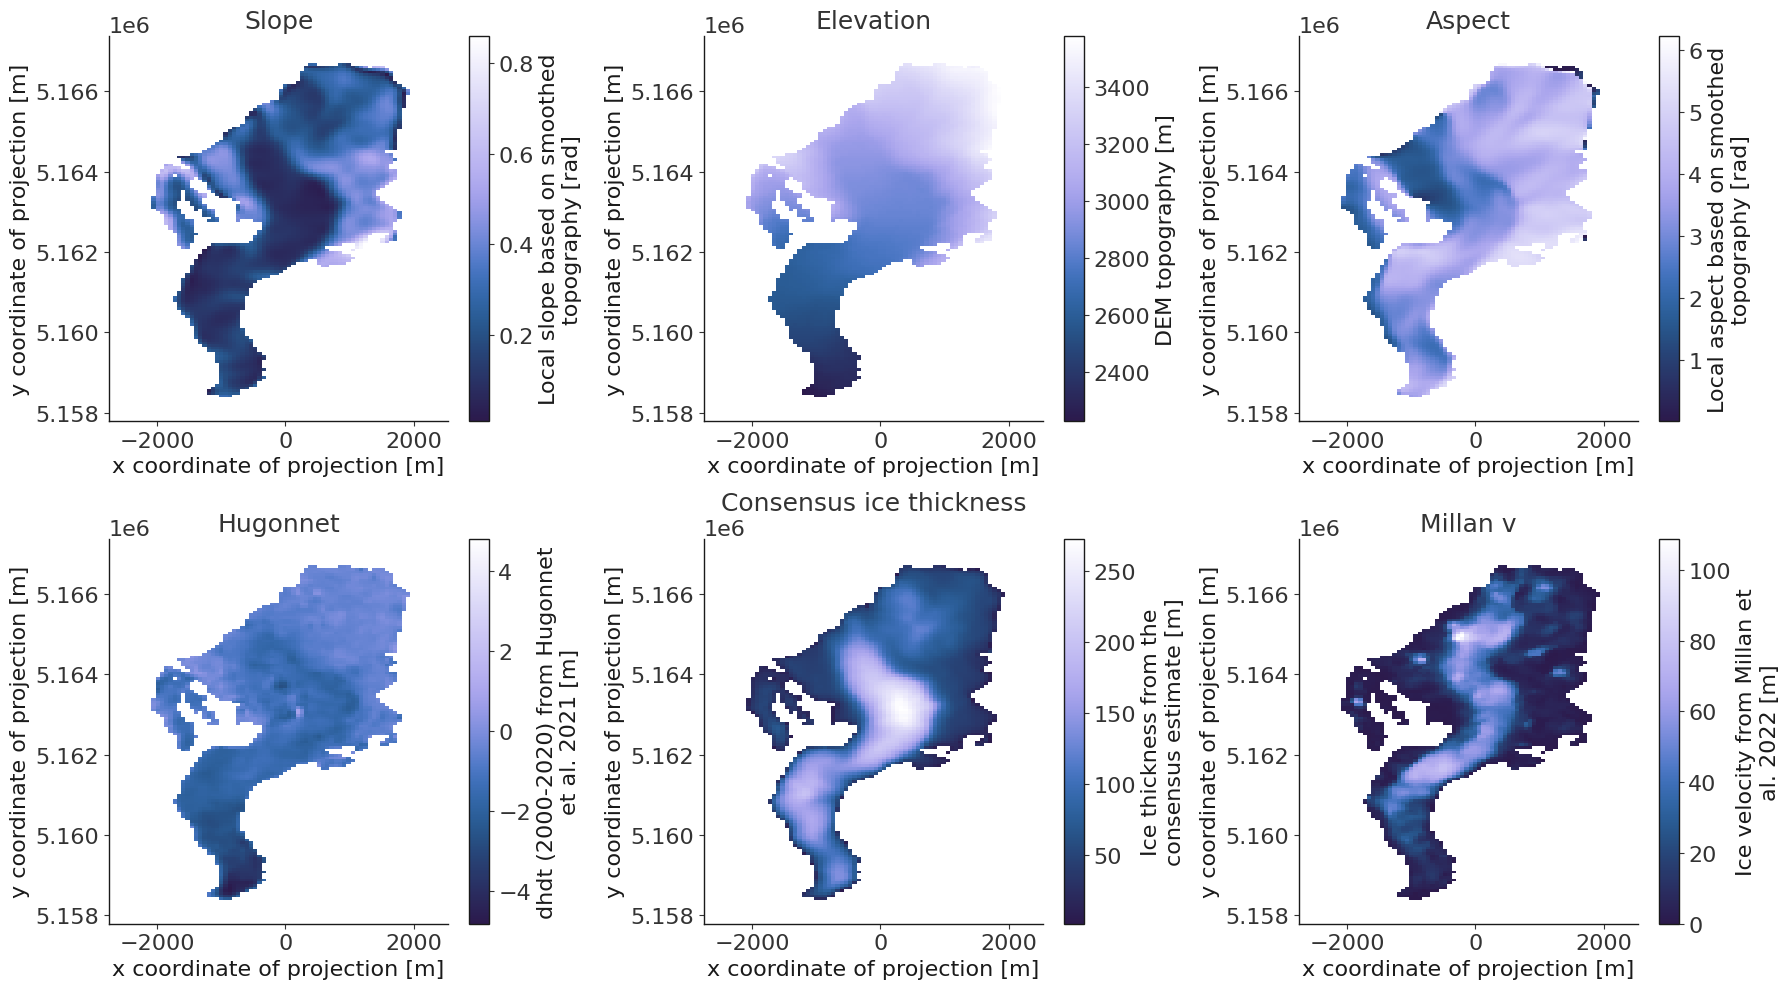

In [10]:
glacierName = 'rhone'
rgi_gl = rgi_overrides.get(glacierName, rgi_df.at[glacierName,
                                                          'rgi_id.v6'])

# Load stake data for that glacier
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)

ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)
# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)